This project takes a dataset of Hourly Energy Consumption from American Electric Power, one of the biggest US electricity providers, traded in the NASDAQ Stock Exchange and with more than 5 million clients.

It aims to extract useful insight on how electricity consumption is distributed accross time and how it has evolved in the past few years.

In [ ]:
import os
from google.colab import drive

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
drive.mount("/content/drive")
data_dir = "/content/drive/My Drive/Codigo/energy consumption"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Get to know the dataset

In [ ]:
df = pd.read_csv(f"{data_dir}/AEP_hourly.csv")

In [ ]:
# Display dataset characteristics
print(f'The dataset has {df.shape} rows and columns')
print(f'The columns are: {df.columns.tolist()}')
print(f'Some statistical values:\n{df.describe()}')
print(f'First rows of the dataset:\n{df.head()}')

The dataset has (121273, 2) rows and columns
The columns are: ['Datetime', 'AEP_MW']
Some statistical values:
              AEP_MW
count  121273.000000
mean    15499.513717
std      2591.399065
min      9581.000000
25%     13630.000000
50%     15310.000000
75%     17200.000000
max     25695.000000
First rows of the dataset:
              Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0


In [ ]:
# Are there any missing or incorrect values?
print(f'NULL values: \n {df.isnull().sum()}')
print(f'NA values: \n {df.isna().sum()}')
print(f'INF values: \n {np.isinf(df["AEP_MW"]).any()}')

NULL values: 
 Datetime    0
AEP_MW      0
dtype: int64
NA values: 
 Datetime    0
AEP_MW      0
dtype: int64
INF values: 
 False


In [ ]:
# How many years does the dataset cover?
print(df.iat[-1,0])
print(df.iat[0,0])

print("The dataset covers approximately 13 years")
print("We can also see that some years are incomplete. 2004 and 2018 only have one day")

2018-01-02 00:00:00
2004-12-31 01:00:00
The dataset covers approximately 13 years
We can also see that some years are incomplete. 2004 and 2018 only have one day


# Preprocessing

In [ ]:
# Convert 'Datetime' to datetime objects
df["Datetime"] = pd.to_datetime(df["Datetime"])

# Add a column with the year
df["Year"] = df["Datetime"].dt.year

# Remove years 2004 and 2018
df = df[(df["Year"] != 2004) & (df["Year"] != 2018)]

# Add a column with the month
df["Month"] = df["Datetime"].dt.month

# Add a column with the day of the week
df["Weekday"] = df["Datetime"].dt.day_name()

print(df.head())

                Datetime   AEP_MW  Year  Month   Weekday
23   2005-01-01 00:00:00  12892.0  2005      1  Saturday
2207 2005-12-31 01:00:00  14254.0  2005     12  Saturday
2208 2005-12-31 02:00:00  13761.0  2005     12  Saturday
2209 2005-12-31 03:00:00  13445.0  2005     12  Saturday
2210 2005-12-31 04:00:00  13306.0  2005     12  Saturday


<ipython-input-7-ebe318c0ed1b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Month"] = df["Datetime"].dt.month
<ipython-input-7-ebe318c0ed1b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Weekday"] = df["Datetime"].dt.day_name()


In [ ]:
# Check how many data points we have for each year. They should be similar,
# with leap years having more days.
df["Year"].value_counts()

,count
Year,
2016,8784
2008,8782
2012,8781
2015,8760
2017,8760
2014,8759
2005,8758
2006,8758
2007,8758


# Extract insights

## Consumption evolution accross years

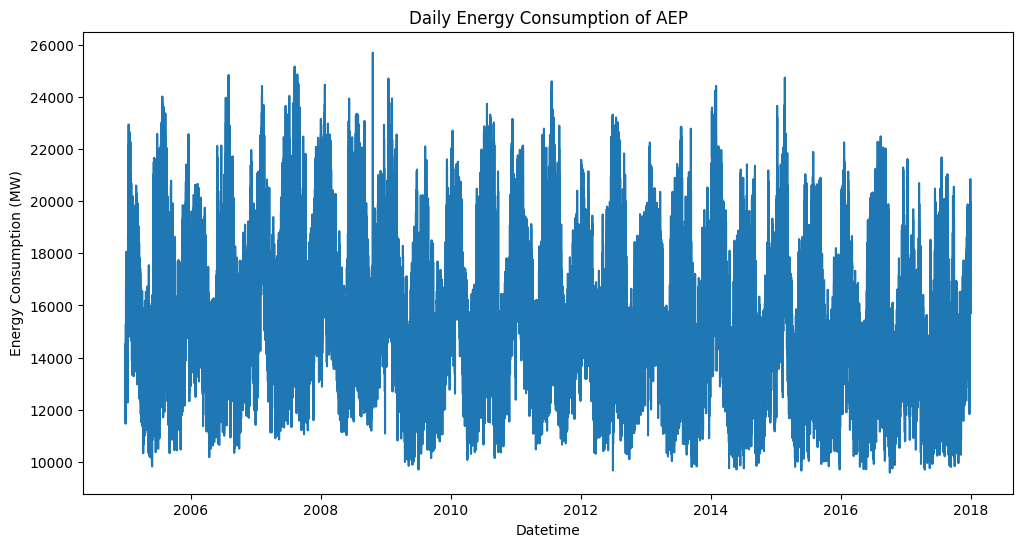

In [ ]:
# Plot all the data

plt.figure(figsize=(12, 6))
sns.lineplot(x=df["Datetime"], y=df["AEP_MW"])
plt.title("Daily Energy Consumption of AEP")
plt.ylabel("Energy Consumption (MW)")
plt.show()

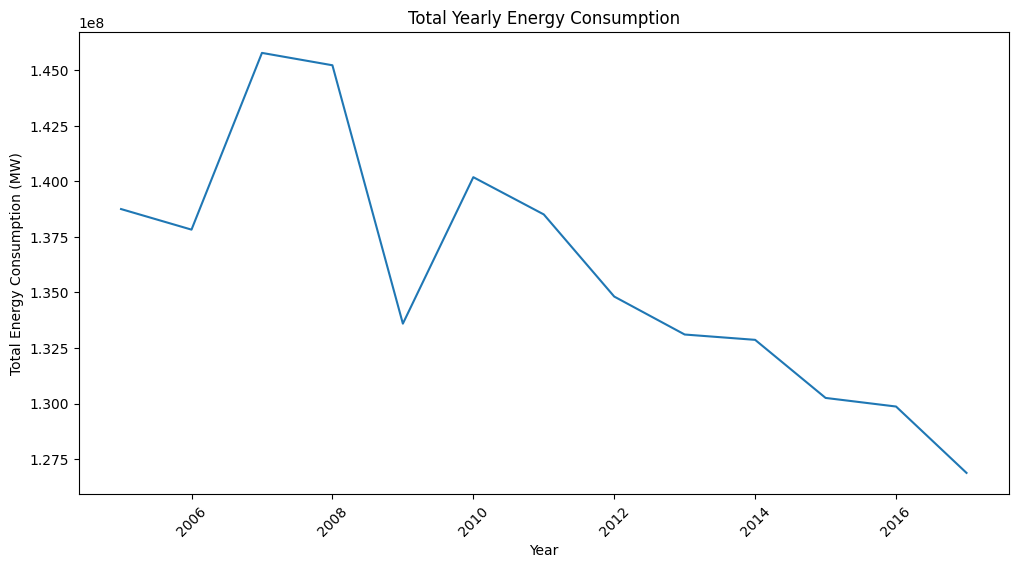

In [ ]:
# Plot the total yearly energy consumption

# Group by year and calculate the total AEP_MW for each year
yearly_total_aep = df.groupby('Year')['AEP_MW'].sum()

# Create a plot using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x=yearly_total_aep.index, y=yearly_total_aep.values)
plt.title('Total Yearly Energy Consumption')
plt.xlabel('Year')
plt.ylabel('Total Energy Consumption (MW)')
plt.xticks(rotation=45)
plt.show()

- Conclussions: There seems to be a fairly consistent decline accross the years, which could be attributed to a drop in the clients of the company. Because of this, it is more interesting to look for differences between months and days if we want to infer consumption patterns.

## Monthly consumption patterns

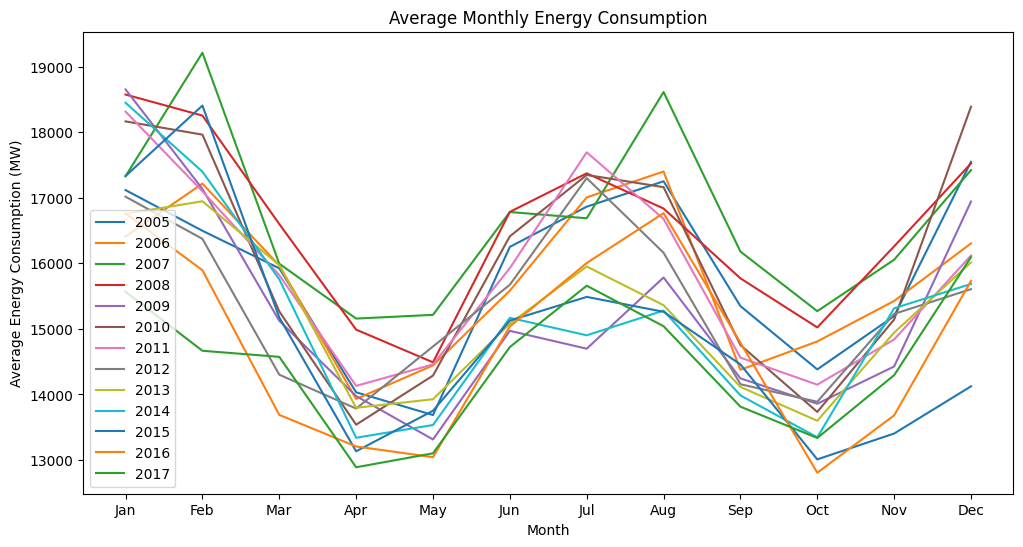

In [ ]:
# Plot the energy consumption by month

# Create a plot using Seaborn
plt.figure(figsize=(12, 6))
df_years = df["Year"].unique().astype(int)

# Add a line for each year in the dataset
for i in df_years:
  monthly_avg = df[df["Year"] == i].groupby('Month')['AEP_MW'].mean()
  sns.lineplot(x=monthly_avg.index, y=monthly_avg.values, label=str(i))

plt.title('Average Monthly Energy Consumption')
plt.xlabel('Month')
plt.ylabel('Average Energy Consumption (MW)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                          'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xticks(range(1, 13))
plt.legend()
plt.show()

- Conclussions: We can see that there is a consistent increase in energy consumption in the months of summer and winter, probably related to the use of HVAC systems.

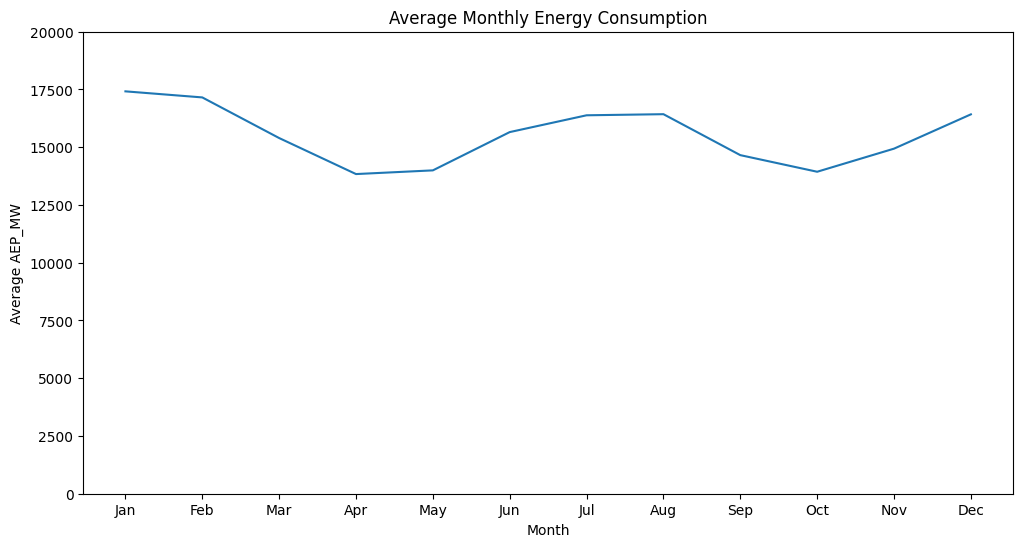

In [ ]:
# Plot the average monthly energy consumption accross the years

# Group by month and calculate the average AEP_MW for each month
monthly_avg_aep = df.groupby('Month')['AEP_MW'].mean()

# Create a plot using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_avg_aep.index, y=monthly_avg_aep.values)
plt.title('Average Monthly Energy Consumption')
plt.xlabel('Month')
plt.ylabel('Average AEP_MW')

# Set x-axis ticks and labels for each month
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                          'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylim(ymin=0)  # Set the y-axis minimum to 0
plt.ylim(ymax=20000)  # Set the y-axis minimum to 0

plt.show()

In [ ]:
# Display the monthly energy consumption increases with respect to the month with the lowest consumption

# Calculate the average energy consumption per month
monthly_avg_aep = df.groupby('Month')['AEP_MW'].mean()

# Find the minimum average consumption
min_avg_consumption = monthly_avg_aep.min()

# Create a new DataFrame to store the results
result_df = pd.DataFrame({'Month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                         'Average Consumption': monthly_avg_aep.values})

# Calculate the percentage increase with respect to the minimum average consumption
result_df['Percentage Increase'] = "+" + (((result_df['Average Consumption']
                                            - min_avg_consumption) / min_avg_consumption)
                                            * 100).round(2).astype(str) + '%'


# Round the average consumption to 2 decimal places
result_df['Average Consumption'] = result_df['Average Consumption'].round(2)

# Display the table
print("Average consumption per month between 2005 and 2017")
print(result_df)

Average consumption per month between 2005 and 2017
   Month  Average Consumption Percentage Increase
0    Jan             17418.68             +25.88%
1    Feb             17156.04             +23.98%
2    Mar             15397.16             +11.27%
3    Apr             13838.06               +0.0%
4    May             13997.89              +1.15%
5    Jun             15655.00             +13.13%
6    Jul             16382.41             +18.39%
7    Aug             16430.04             +18.73%
8    Sep             14657.28              +5.92%
9    Oct             13938.27              +0.72%
10   Nov             14938.10              +7.95%
11   Dec             16423.13             +18.68%


Conclussions: The months with the highest average consumption are January and February, while the ones with the lowest are April and October. The consumption difference between them amounts to 25%.

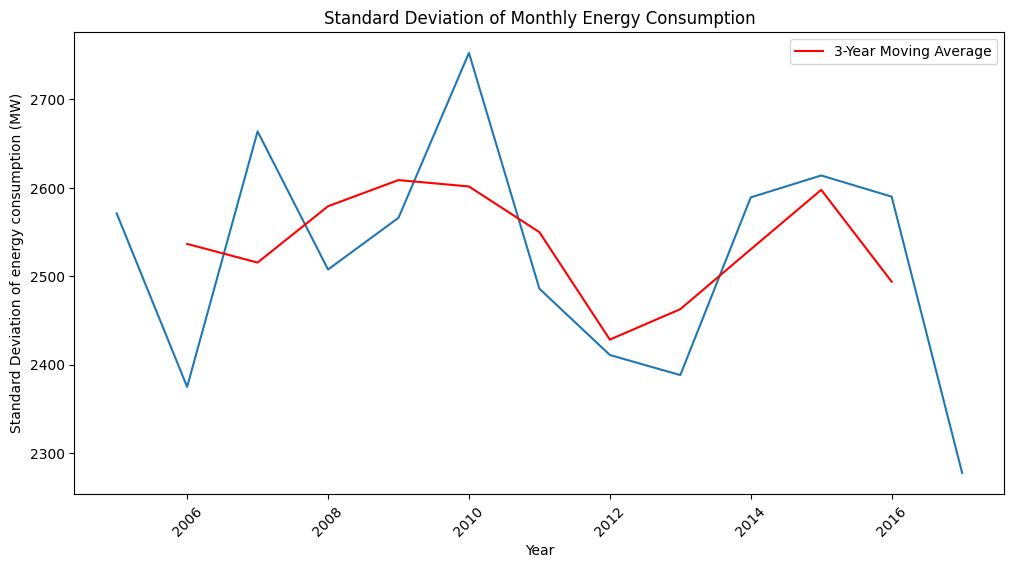

In [ ]:
# Check if the monthly differences have increased by plotting the monthly standard deviation

# Group by year and calculate the standard deviation of Energy Consumption for each year
yearly_std_aep = df.groupby('Year')['AEP_MW'].std()

# Create a plot using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x=yearly_std_aep.index, y=yearly_std_aep.values)

# Add the 3-year moving average
yearly_std_aep_rolling = yearly_std_aep.rolling(window=3, center=True).mean()
sns.lineplot(x=yearly_std_aep_rolling.index, y=yearly_std_aep_rolling.values, label='3-Year Moving Average', color='red')

plt.title('Standard Deviation of Monthly Energy Consumption')
plt.xlabel('Year')
plt.ylabel('Standard Deviation of energy consumption (MW)')
plt.xticks(rotation=45)
plt.show()

- Conclussions: It does not seem clear that the energy consumption variation by month has neither increased nor decreased during the studied timeframe.


## Daily consumption patterns

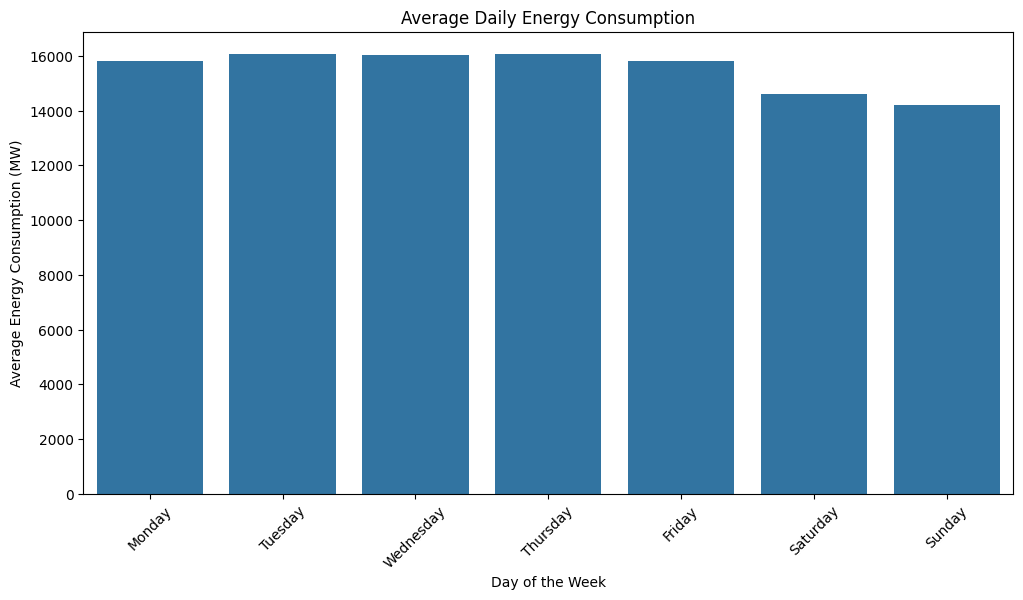

In [ ]:
# Plot the energy consumption by day of the week

# Group by day of the week and calculate the average AEP_MW for each day
average_aep_by_day = df.groupby('Weekday')['AEP_MW'].mean()

# Define the desired order of days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reindex the average_aep_by_day Series to match the desired order
average_aep_by_day = average_aep_by_day.reindex(day_order)

# Create a plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=average_aep_by_day.index, y=average_aep_by_day.values)

plt.title('Average Daily Energy Consumption')
plt.xlabel('Day of the Week')
plt.ylabel('Average Energy Consumption (MW)')

# Set x-axis ticks and labels to day names
plt.xticks(rotation=45)

plt.show()

In [ ]:
# Display the daily energy consumption increases with respect to the day with the lowest consumption

# Calculate the average energy consumption per day
daily_avg_aep = df.groupby('Weekday')['AEP_MW'].mean()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg_aep = average_aep_by_day.reindex(day_order)

# Find the minimum average consumption
min_avg_consumption = daily_avg_aep.min()

# Create a new DataFrame to store the results
result_df = pd.DataFrame({'Day': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
                                    'Sun'],
                         'Average Consumption': daily_avg_aep.values})

# Calculate the percentage increase with respect to the minimum average consumption
result_df['Percentage Increase'] = "+" + (((result_df['Average Consumption']
                                            - min_avg_consumption) / min_avg_consumption)
                                            * 100).round(2).astype(str) + '%'

# Round the average consumption to 2 decimal places
result_df['Average Consumption'] = result_df['Average Consumption'].round(2)

# Display the table
print("Average consumption per day between 2005 and 2017")
print(result_df)

Average consumption per day between 2005 and 2017
   Day  Average Consumption Percentage Increase
0  Mon             15814.18             +11.29%
1  Tue             16072.11             +13.11%
2  Wed             16035.81             +12.85%
3  Thu             16056.42              +13.0%
4  Fri             15801.34              +11.2%
5  Sat             14618.60              +2.88%
6  Sun             14209.69               +0.0%


- Conclussions: The weekends have an inferior energy consumption, Sunday being the day with the lowest consumption among them.

## Hourly consumption patterns

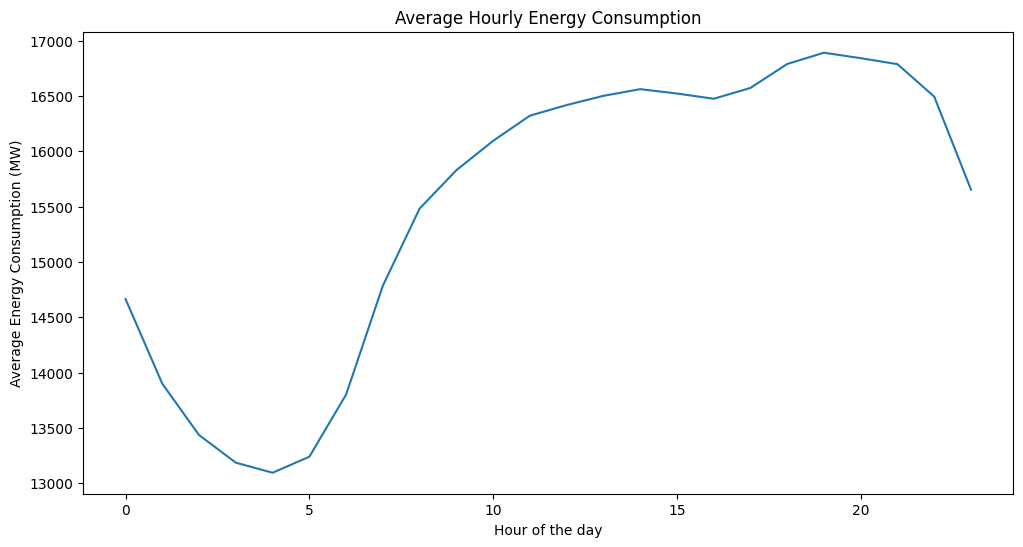

In [ ]:
# Plot hourly energy consumption

# Add a column with the hour of the day
df['Hour'] = df['Datetime'].dt.hour

# Group by hour and calculate the average AEP_MW for each hour
hourly_avg_aep = df.groupby('Hour')['AEP_MW'].mean()

# Create a plot using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_avg_aep.index, y=hourly_avg_aep.values)

plt.title('Average Hourly Energy Consumption')
plt.xlabel('Hour of the day')
plt.ylabel('Average Energy Consumption (MW)')

plt.show()

In [ ]:
# Display the average energy consumption per hour

# Calculate the average energy consumption per hour
hourly_avg_aep = df.groupby('Hour')['AEP_MW'].mean()

# Find the minimum average consumption
min_avg_consumption = hourly_avg_aep.min()

# Create a new DataFrame to store the results
result_df = pd.DataFrame({'Hour': range(24),
                         'Average Consumption': hourly_avg_aep.values})

# Calculate the percentage increase with respect to the minimum average consumption
result_df['Percentage Increase'] = "+" + (((result_df['Average Consumption']
                                            - min_avg_consumption) / min_avg_consumption)
                                            * 100).round(2).astype(str) + '%'

# Round the average consumption to 2 decimal places
result_df['Average Consumption'] = result_df['Average Consumption'].round(2)

# Display the table
print("Average consumption per hour between 2005 and 2017")
print(result_df)

Average consumption per hour between 2005 and 2017
    Hour  Average Consumption Percentage Increase
0      0             14665.26             +11.98%
1      1             13899.76              +6.14%
2      2             13436.07               +2.6%
3      3             13186.58              +0.69%
4      4             13095.80               +0.0%
5      5             13240.35               +1.1%
6      6             13802.47               +5.4%
7      7             14786.06             +12.91%
8      8             15483.14             +18.23%
9      9             15829.59             +20.88%
10    10             16095.12              +22.9%
11    11             16322.46             +24.64%
12    12             16418.42             +25.37%
13    13             16501.61             +26.01%
14    14             16562.08             +26.47%
15    15             16522.63             +26.17%
16    16             16475.22             +25.81%
17    17             16572.95             +26.55%

- Conclussions: energy consumption increases at evening by an amount closer to 30% in respect to the midnight, which is not as high as one could think of. There seems to be a lot of energy consumption during midnight.